# EDA summary (Group 2)

In this EDA we tried to answer the following questions:

[**Question 2**](#Ans_To_Q2a)
- ([a](#Ans_To_Q2a))	Impact of the basic facilities (e.g. num_bath_room, num_bed_room) we recorded on the property prices
- ([b](#Ans_To_Q2b))	Impact of facilities (malls, educational institutions, business hubs, hospitals, ...) in the vicinity on the prices
- ([c](#Ans_To_Q2c))	Impact of internal amenities (play area, number of car parks, height of the building, number of storeys, number of total amenities) on the prices
- ([d](#Ans_To_Q2d))	How do they influence the price: linearly / non-linearly / stepwise?

[**Question 8**](#Ans_To_Q8)
- Mean prices per building_type (apartment/shop/...); the goal is to understand if it is worth it to have such an attribute, or if building_nature (commercial/residential) is enough.

<br>

<font color=black>**Summary of answers:**</font>

1. <font color=gray>**Answers to Question 2 (a+d)**</font>
    - We see that the influence of "area" (size in Sq. ft) on price is more straightforwardly visible for "Aparments" under "Sale" purpose such that there is a linear increase in price with increase in area. For "Aparments" under "Rent" the picture is not that clear--there doesn't seem to be a direct linear relationship ([see this](#price-vs-area-plot)). Note that:
        - There are only about 20% properties in the dataset that have some info about the area of the property ([see this](#area-missing-val)).
        - Close to 80% of the properties are of type 'Apartment' ([see this](#property-type-frequency)).
        - → **This possibly means that we have very little info about other property types, and the number of data points with info about 'area' is probably not sufficient**
    - The impact of both, the number of bathrooms and bedrooms on price *seems to be* linear (could even be exponential), and again the pattern is clearer for "Sale" purpose than for "Rent" purpose (for bathrooms [see this](#price-vs-bathroom) and for bedrooms [see this](#price-vs-bedroom)). Note that:
        - The info is not available (or is zero) for bathrooms in around 40%, and for bedrooms, in around 20% of the data ([see this](#bath-bed-Zero))


2. <font color=gray>**Answer to Question 2 (b)**</font>
    - This question cannot be answered because the required info about these facilities is not available in the dataset


3. <font color=gray>**Answer to Question 2 (c)**</font>
    - Since we don't have separate info about these amenities, we analyzed the impact of different types of amenities on price. Again, the picture is clearer for "Sale" purpose than for "Rent" purpose, and the relationship seems exponetial such that the price increases exponetially with the number of amenities ([see this](#price-vs-amenities-plot)). Note that:
        - For almost all the amenities in around 60-90% of the data, the amenity value is missing (or is zero) ([see this](#zeros-in-amenities-plot))


4. <font color=gray>**Answer to Question 8**</font>
    - [This plot](#price-by-type) answers the question.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

from numpy import median

In [22]:
# Dataset downloaded on 01 May 2023 at 08:30 hrs (CEST)
df_merged = pd.read_csv("merged_datasets_01_05_2023.csv")

In [23]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41546 entries, 0 to 41545
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   area                                   39274 non-null  object 
 1   building_type                          41248 non-null  object 
 2   building_nature                        41546 non-null  object 
 3   image_url                              17312 non-null  object 
 4   num_bath_rooms                         41546 non-null  float64
 5   num_bed_rooms                          41546 non-null  float64
 6   price                                  40466 non-null  float64
 7   property_description                   23665 non-null  object 
 8   property_overview                      20194 non-null  object 
 9   property_url                           39146 non-null  object 
 10  purpose                                40841 non-null  object 
 11  ci

### First, some data wrangling!!

#### Correct '_area_' values
**NOTE: Area is not numeric because some values have extra string: 'sft', '(Sft)' and ' gross'**
<br>
Get rid of extra strings and convert it to numeric values (float)

In [24]:
df_merged['area'] = np.where(df_merged['area'].str.contains(' sft'), df_merged['area'].str.split(' ')[0], 
                             np.where(df_merged['area'].str.contains('\(Sft\)'), df_merged['area'].str.split('\(')[0],
                                      np.where(df_merged['area'].str.contains(' gross'), 
                                          df_merged['area'].str.split(' ')[0], df_merged['area'])
                                     )
                            )

In [25]:
df_merged['area'] = df_merged['area'].astype(float)

In [26]:
df_merged.area.describe(percentiles=[.1, .3, .6, .9, 0.95, .99])

count    8.775000e+03
mean     8.065880e+03
std      2.754335e+05
min      0.000000e+00
10%      0.000000e+00
30%      6.000000e+02
50%      1.050000e+03
60%      1.200000e+03
90%      2.160000e+03
95%      2.762300e+03
99%      7.940800e+03
max      1.450147e+07
Name: area, dtype: float64

<br>

#### Make '_building_type_' types as smaller set

**NOTE: There seems to be some repetitions of types. Let's combine the related values into unique types**

In [27]:
df_merged['building_type'].value_counts()

Apartment                       28990
 Apartment                       2374
Office                           2340
Building                         1422
Land                             1342
Shop                             1064
Floor                             885
Plot                              809
Apartment/Flats                   611
Garage                            457
Commercial Space                  249
House                             221
Residential Plot                  164
Duplex                             91
Office space                       52
Warehouse                          39
Factory                            26
Land Sharing Flat                  24
Office Space                       24
Showroom/Shop/Restaurant           16
Independent House                   9
Duplex Home                         9
Commercial Plot                     8
Industrial Space                    6
Commerical - Other                  4
Sublet/Room                         4
Commercial p

In [28]:
# Combine the related values into one

# The following types are combined into one
# 
# Apartment: Apartment;  Apartment/Flats;  Apartment, Commercial
# Office:  Office;  Office space
# Commercial Space:  Commercial Space;  Commerical - Other;  Commercial property
# Shop:  Shop;  Showroom / Shop / Restaurant
# House:  House;  Independent House
# Duplex:  Duplex;  Duplex Home

# Create a new column
df_merged['building_type_comb'] = df_merged['building_type']

df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains('Apartment'), 
                                          'Apartment', df_merged['building_type_comb'])

df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains('Office'), 
                                          'Office', df_merged['building_type_comb'])

df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains('Commercial'), 
                                          'Commercial Space', df_merged['building_type_comb'])

# Correct the typo!
df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains('Commerical'), 
                                          'Commercial Space', df_merged['building_type_comb'])

df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains('Shop'), 
                                          'Shop', df_merged['building_type_comb'])

df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains('House'), 
                                          'House', df_merged['building_type_comb'])

# Although a 'Duplex' is a special kind of 'House', let's keep it as a separate type
df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains('Duplex'), 
                                          'Duplex', df_merged['building_type_comb'])


In [29]:
df_merged['building_type_comb'].value_counts()

Apartment                32275
Office                    2416
Building                  1422
Land                      1342
Shop                      1082
Floor                      885
Plot                       809
Garage                     457
Commercial Space           263
House                      230
Residential Plot           164
Duplex                     100
Warehouse                   39
Factory                     26
Land Sharing Flat           24
Industrial Space             6
Sublet/Room                  4
Agriculture/Farm Land        1
 Condos                      1
Name: building_type_comb, dtype: int64

In [30]:
# And since the rest of the property types have very few occurences, let's club them together as 'other'
df_merged['building_type_comb'] = np.where(df_merged['building_type_comb'].str.contains(
    'Warehouse|Factory|Land Sharing Flat|Industrial Space|Sublet/Room|Agriculture/Farm Land| Condos'), 
                                          'other', df_merged['building_type_comb'])

In [31]:
df_merged['building_type_comb'].value_counts()

Apartment           32275
Office               2416
Building             1422
Land                 1342
Shop                 1082
Floor                 885
Plot                  809
Garage                457
Commercial Space      263
House                 230
Residential Plot      164
other                 101
Duplex                100
Name: building_type_comb, dtype: int64

In [32]:
df_merged['building_type_comb'].value_counts().sum()

41546

In [33]:
df_merged.shape

(41546, 25)

#### Make 'num_bath_rooms' and 'num_bed_rooms' integer from float

In [34]:
df_merged['num_bath_rooms'] = df_merged['num_bath_rooms'].astype('int64')
df_merged['num_bed_rooms'] = df_merged['num_bed_rooms'].astype('int64')

<br>

#### Correct the values in '_purpose_'

In [35]:
df_merged['purpose'].unique()

array(['Sale', 'Rent', nan, 'sale', 'SALE', 'rent'], dtype=object)

In [36]:
df_merged['purpose'].value_counts()

Rent    23428
Sale    16813
sale      598
SALE        1
rent        1
Name: purpose, dtype: int64

In [37]:
df_merged['purpose'] = np.where(df_merged['purpose'].str.contains('sale|SALE'), 'Sale', 
                             np.where(df_merged['purpose'].str.contains('rent'), 'Rent', 
                                      df_merged['purpose'])
                                     )

In [38]:
df_merged['purpose'].value_counts()

Rent    23429
Sale    18117
Name: purpose, dtype: int64

In [39]:
df_merged['garage'].value_counts()

0.0    41347
1.0      190
2.0        8
4.0        1
Name: garage, dtype: int64

<a id='Ans_To_Q2a'></a>
# Question: 2
## (a)	Impact of the basic facilities on property prices
**{_area_, _num_bath_rooms_, _num_bed_rooms}**

### Impact of '_area_'


In [40]:
# Distribution of prices for 'Rent'
percl_price_Rent = df_merged[(df_merged.purpose == 'Rent')
                               ].price.describe(percentiles=[0.02, .3, .6, .9, 0.95, .99])
print(percl_price_Rent)

count    2.315600e+04
mean     1.092878e+07
std      8.266022e+08
min      0.000000e+00
2%       0.000000e+00
30%      1.800000e+04
50%      3.200000e+04
60%      5.000000e+04
90%      4.500000e+05
95%      8.000000e+05
99%      2.500000e+06
max      1.000000e+11
Name: price, dtype: float64


In [41]:
# Distribution of prices for 'Sale'
percl_price_Sale = df_merged[(df_merged.purpose == 'Sale')
                               ].price.describe(percentiles=[0.02, .3, .6, .9, 0.95, .99])
print(percl_price_Sale)

count    1.731000e+04
mean     2.077500e+09
std      1.839185e+11
min      0.000000e+00
2%       4.500000e+05
30%      5.337000e+06
50%      7.200000e+06
60%      8.220000e+06
90%      2.000000e+07
95%      3.500000e+07
99%      6.500000e+08
max      2.400000e+13
Name: price, dtype: float64


In [42]:
# Distribution of area for 'Rent'
percl_area_Rent = df_merged[(df_merged.purpose == 'Rent')
                               ].area.describe(percentiles=[0.05, .3, .6, .9, 0.95, .99])
print(percl_area_Rent)

count    5.465000e+03
mean     1.190663e+04
std      3.489082e+05
min      0.000000e+00
5%       0.000000e+00
30%      0.000000e+00
50%      6.500000e+02
60%      8.000000e+02
90%      2.000000e+03
95%      2.650000e+03
99%      1.000000e+04
max      1.450147e+07
Name: area, dtype: float64


In [43]:
# Distribution of area for 'Sale'
percl_area_Sale = df_merged[(df_merged.purpose == 'Sale')
                               ].area.describe(percentiles=[0.05, .3, .6, .9, 0.95, .99])
print(percl_area_Sale)

count      3310.000000
mean       1724.581420
std        8567.220496
min           3.000000
5%          830.900000
30%        1200.000000
50%        1375.000000
60%        1480.000000
90%        2200.000000
95%        2900.000000
99%        4350.000000
max      490000.000000
Name: area, dtype: float64


In [44]:
# df_rent_all_area = df_merged[df_merged.purpose == 'Rent']
# df_rent_upto95_area = df_rent_all_area[df_rent_all_area.area <= percl_area_Rent['95%']]

# print(df_rent_all_area.shape)
# print(df_rent_upto95_area.shape)


<a id='area-missing-val'></a>
#### How many properties have the '_area_' info?

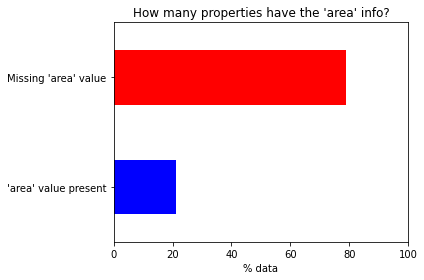

In [45]:
df_TMP = pd.Series(np.where(df_merged['area'].isna(), "Missing 'area' value", "'area' value present"))
percentages = (df_TMP.value_counts() / df_TMP.value_counts().sum()) * 100

#     print()
#     print("------------------------------------")
#     print(percentages)

fig, ax = plt.subplots(figsize=(6, 4))
percentages.sort_index().plot.barh(color=['blue', 'red'])

# Set x and y axis labels
plt.xlabel('% data')
plt.ylabel('')
# plt.title(f"'{col_name}': zero vs. non-zero entries")
plt.title("How many properties have the 'area' info?")
ax.set_xlim(0, 100)

plt.tight_layout()

# Show the plot
plt.show()


<a id='property-type-frequency'></a>
#### How many data points do we have for each type of property?

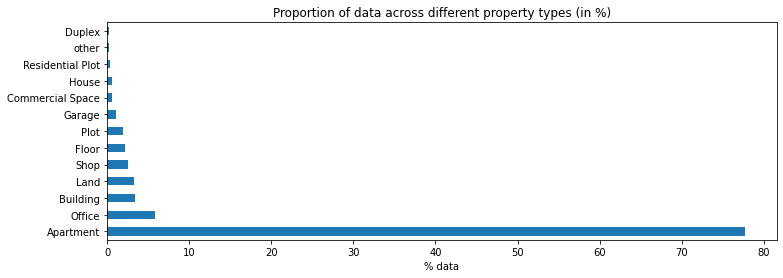

In [46]:
freq = (df_merged['building_type_comb'].value_counts() / df_merged['building_type_comb'].value_counts().sum()) * 100

fig, ax = plt.subplots(figsize=(12, 4))
freq.plot.barh()

plt.title("Proportion of data across different property types (in %)")
plt.xlabel("% data")

plt.show()

<a id='price-vs-area-plot'></a>

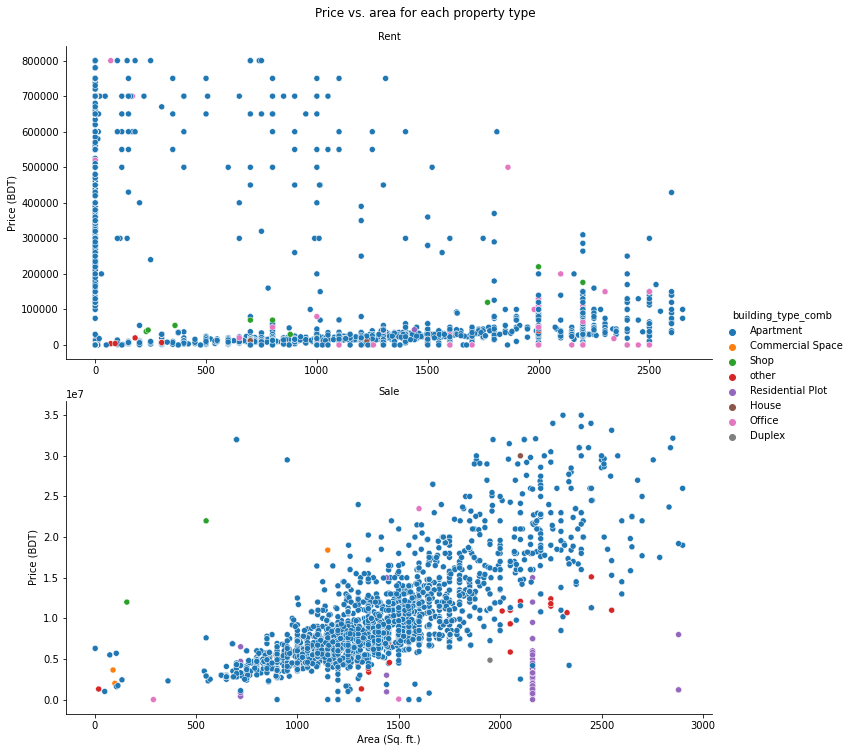

In [63]:
# Prepare / subset the data:
# Get all the data that has price and area outliers removed (= all values above 95 percentile)
data = df_merged[((df_merged.purpose == 'Rent') &
                  (df_merged.area <= percl_area_Rent['95%']) & 
                  (df_merged.price <= percl_price_Rent['95%'])
                 ) | 
                 ((df_merged.purpose == 'Sale') & 
                  (df_merged.area <= percl_area_Sale['95%']) & 
                  (df_merged.price <= percl_price_Sale['95%'])
                 )
                 ]

g = sns.relplot(y="price", x="area", 
                data = data,
                row = "purpose",
                hue = "building_type_comb",
#                 size = "num_bed_rooms",
                kind="scatter",
                facet_kws={'sharey': False, 'sharex': False},
                height=5, aspect=2
               )

g.set_titles('{row_name}', fontsize=24)
g.set_axis_labels('Area (Sq. ft.)', 'Price (BDT)')

# g.fig.suptitle('Price vs. area for each property type and purpose', fontsize=12, y=1.02)
g.fig.suptitle('Price vs. area for each property type', fontsize=12, y=1.02)
plt.plot()

g.savefig('Price-vs-Area-Scatterplot.jpg')

<br>

### Impact of '_num_bath_rooms_'  and '_num_bed_rooms_'

[]

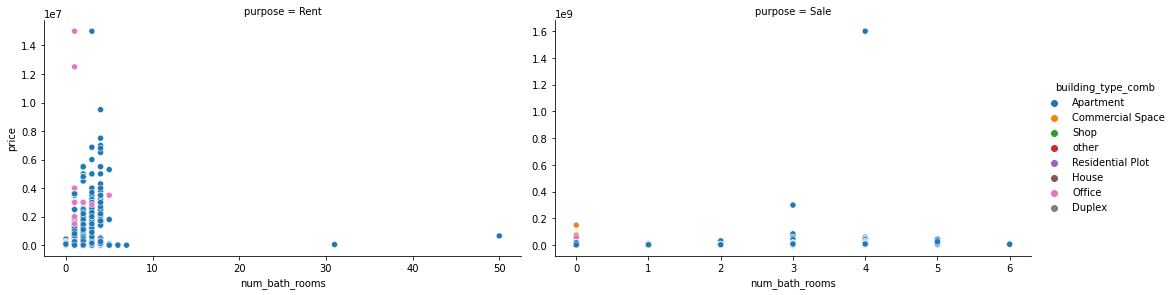

In [66]:
g = sns.relplot(y="price", x="num_bath_rooms", 
                data = df_merged[(((df_merged.purpose == 'Rent') & 
                                      (df_merged.area <= percl_area_Rent['95%'])) | 
                                     ((df_merged.purpose == 'Sale') & 
                                      (df_merged.area <= percl_area_Sale['95%'])
                                     ))],
                col = "purpose",
                hue = "building_type_comb",
                kind="scatter",
                facet_kws={'sharey': False, 'sharex': False},
                height=4, aspect=1.8
               )
# g.fig.set_size_inches(10, 10)
plt.plot()

[]

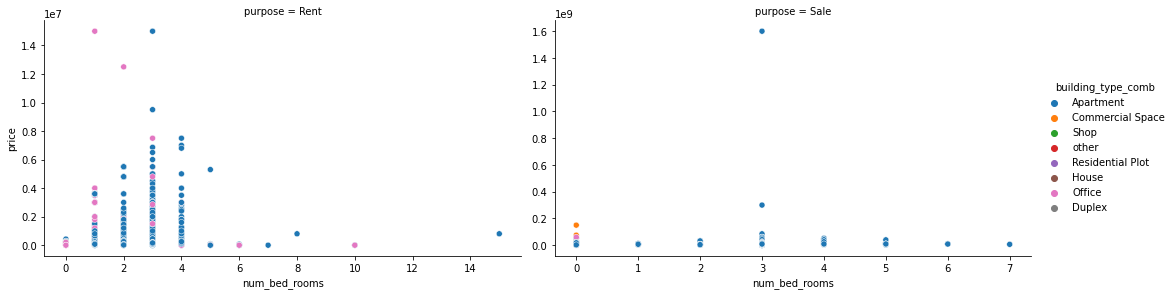

In [67]:
g = sns.relplot(y="price", x="num_bed_rooms", 
                data = df_merged[(((df_merged.purpose == 'Rent') & 
                                      (df_merged.area <= percl_area_Rent['95%'])) | 
                                     ((df_merged.purpose == 'Sale') & 
                                      (df_merged.area <= percl_area_Sale['95%'])
                                     ))],
                col = "purpose",
                hue = "building_type_comb",
                kind="scatter",
                facet_kws={'sharey': False, 'sharex': False},
                height=4, aspect=1.8
               )
# g.fig.set_size_inches(50, 5)
plt.plot()




#### The individual scatterplots by 'building_type'  for 'price' vs. 'num_bath_rooms' / 'num_bed_rooms' don't seem very informative

**==> Let's use plot the distribution of 'price' for each value of 'num_bath_rooms' / 'num_bed_rooms'**

In [1170]:
print(df_merged[df_merged.num_bath_rooms == 0].shape)
print(df_merged[df_merged.num_bed_rooms == 0].shape)

(16060, 25)
(9118, 25)


#### Missing or zero values for 'num_bath_rooms' / 'num_bed_rooms'

In [1171]:
df_merged['is_num_bath_ZERO'] = np.where(df_merged['num_bath_rooms'] == 0, 'Yes', 'No')
df_merged['is_num_bed_ZERO'] = np.where(df_merged['num_bed_rooms'] == 0, 'Yes', 'No')

<a id='bath-bed-Zero'></a>

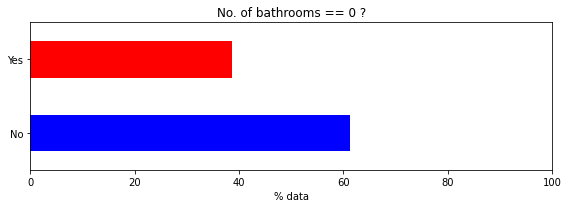

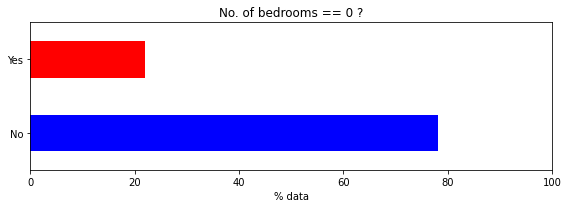

In [1172]:
# BATHROOMS
freq = (df_merged['is_num_bath_ZERO'].value_counts() / df_merged['is_num_bath_ZERO'].value_counts().sum()) * 100

fig, ax = plt.subplots(figsize=(8, 3))
freq.plot.barh(color=['blue', 'red'])

plt.title("No. of bathrooms == 0 ?")
plt.xlabel("% data")
ax.set_xlim(0, 100)
plt.tight_layout()

plt.show()


# BEDROOMS
freq = (df_merged['is_num_bed_ZERO'].value_counts() / df_merged['is_num_bed_ZERO'].value_counts().sum()) * 100

fig, ax = plt.subplots(figsize=(8, 3))
freq.plot.barh(color=['blue', 'red'])

plt.title("No. of bedrooms == 0 ?")
plt.xlabel("% data")
ax.set_xlim(0, 100)
plt.tight_layout()

plt.show()

In [1173]:
max_bath_sale = df_merged[df_merged['purpose'] == 'Sale'].num_bath_rooms.max()
print(max_bath_sale)

max_bath_rent = df_merged[df_merged['purpose'] == 'Rent'].num_bath_rooms.max()
print(max_bath_rent)

36
50


<a id='price-vs-bathroom'></a>


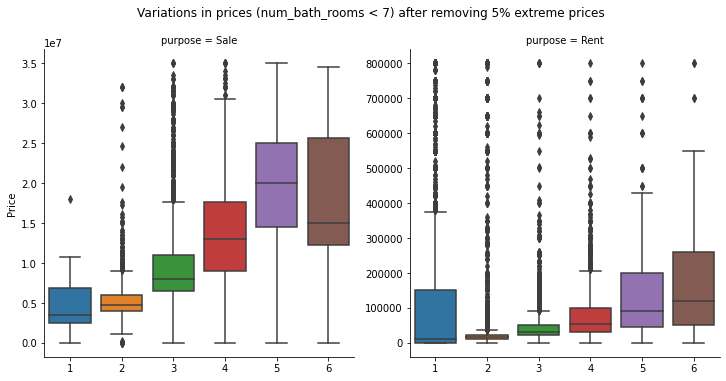

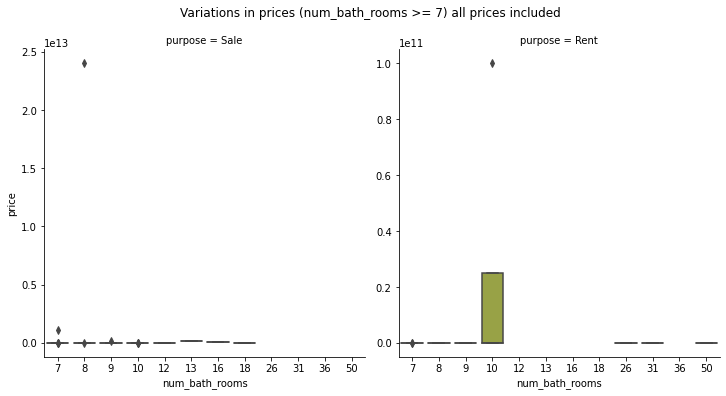

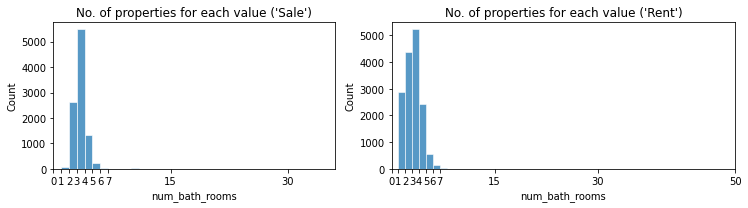

In [1174]:
# First row ==============>
# 
# plt.figure(figsize=(12, 3))
g = sns.catplot(y="price", x="num_bath_rooms", 
            data = df_merged[(((df_merged.purpose == 'Rent') & 
                                  (df_merged.price <= percl_price_Rent['95%'])
                                 ) |
                                 ((df_merged.purpose == 'Sale') & 
                                  (df_merged.price <= percl_price_Sale['95%'])
                                 )
                                ) &
                                (df_merged.num_bath_rooms > 0) &
                                (df_merged.num_bath_rooms <= 6)
                                   ], 
                kind="box",
               col= "purpose", 
               sharey = False
           )

g.set_axis_labels('', 'Price')

# Add row title
fig = g.fig
# fig.suptitle(f'Row: {row_var}', y=1.05)
fig.suptitle('Variations in prices (num_bath_rooms < 7) after removing 5% extreme prices', y=1.05)

plt.plot()


# Second row ==============>
# 
# plt.figure(figsize=(12, 3))
g = sns.catplot(y="price", x="num_bath_rooms", 
            data = df_merged[(df_merged.num_bath_rooms > 6)],
                kind="box",
               col= "purpose", 
               sharey = False
           )

# Add row title
fig = g.fig
fig.suptitle('Variations in prices (num_bath_rooms >= 7) all prices included', y=1.05)

# plt.title("")
plt.plot()


# Third row ==============>
# 
# Create subplots with different widths
fig = plt.figure(figsize=(10.5, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.45, 0.55])


# Plot histogram 1
ax1 = plt.subplot(gs[0])
sns.histplot(x="num_bath_rooms", 
             data = df_merged[(df_merged.num_bath_rooms > 0) & (df_merged['purpose'] == 'Sale')], 
             binwidth=1, edgecolor='white', ax=ax1)
ax1.set_xlim(0, max_bath_sale)
ax1.set_title("No. of properties for each value ('Sale')")
# plt.title("No. of properties for each value of num_bath_rooms ('Sale' + 'Rent')")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 15, 30])

ax2 = plt.subplot(gs[1])
sns.histplot(x="num_bath_rooms", 
             data = df_merged[(df_merged.num_bath_rooms > 0) & (df_merged['purpose'] == 'Rent')], 
             binwidth=1, edgecolor='white', ax=ax2)
ax2.set_xlim(0, max_bath_rent)
ax2.set_title("No. of properties for each value ('Rent')")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 15, 30, 50])
# plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 10, 20, 35])

# Adjust spacing between subplots
plt.tight_layout()

# plt.plot()
plt.show()

<a id='price-vs-bedroom'></a>

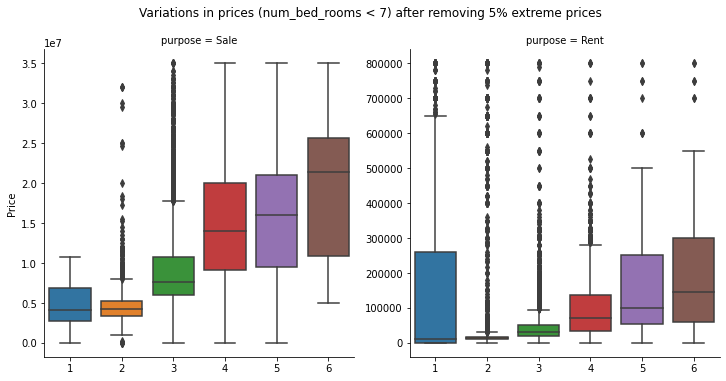

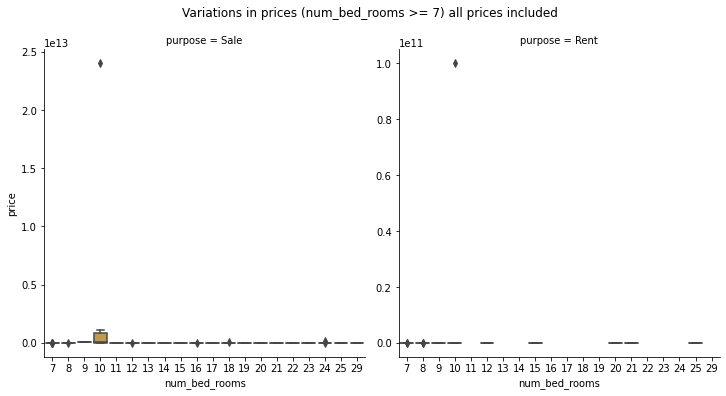

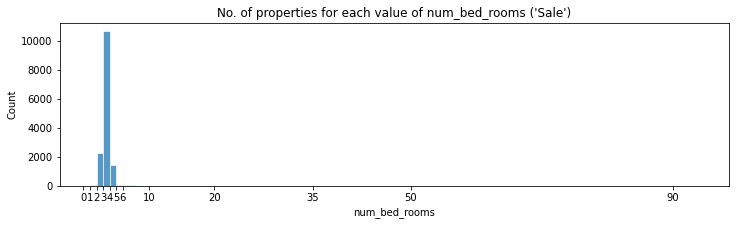

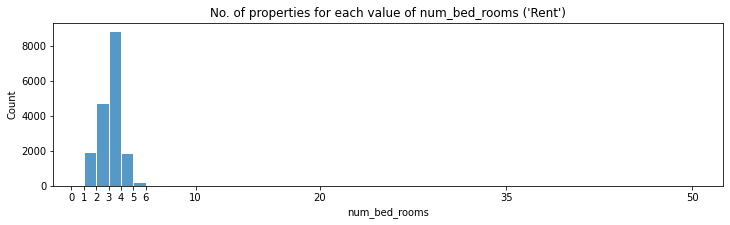

In [1175]:
# First row ==============>
# 
# plt.figure(figsize=(12, 3))
g = sns.catplot(y="price", x="num_bed_rooms", 
            data = df_merged[(((df_merged.purpose == 'Rent') & 
                                  (df_merged.price <= percl_price_Rent['95%'])
                                 ) |
                                 ((df_merged.purpose == 'Sale') & 
                                  (df_merged.price <= percl_price_Sale['95%'])
                                 )
                                ) &
                                (df_merged.num_bed_rooms > 0) &
                                (df_merged.num_bed_rooms <= 6)
                                   ], 
                kind="box",
               col= "purpose", 
               sharey = False
           )

g.set_axis_labels('', 'Price')

# Add row title
fig = g.fig
# fig.suptitle(f'Row: {row_var}', y=1.05)
fig.suptitle('Variations in prices (num_bed_rooms < 7) after removing 5% extreme prices', y=1.05)

plt.plot()


# Second row ==============>
# 
# plt.figure(figsize=(12, 3))
g = sns.catplot(y="price", x="num_bed_rooms", 
            data = df_merged[(df_merged.num_bed_rooms > 6) &
                                (df_merged.num_bed_rooms < 30)
                                   ],
                kind="box",
               col= "purpose", 
               sharey = False
           )

# Add row title
fig = g.fig
fig.suptitle('Variations in prices (num_bed_rooms >= 7) all prices included', y=1.05)

# plt.title("")
plt.plot()


plt.show()


# # Third row ==============>

plt.figure(figsize=(12, 3))

sns.histplot(x="num_bed_rooms", 
             data = df_merged[(df_merged.num_bed_rooms > 0) & (df_merged['purpose'] == 'Sale')], 
             binwidth=1, edgecolor='white')
plt.title("No. of properties for each value of num_bed_rooms ('Sale')")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 10, 20, 35, 50, 90])
plt.plot()

plt.figure(figsize=(12, 3))

sns.histplot(x="num_bed_rooms", 
             data = df_merged[(df_merged.num_bed_rooms > 0) & (df_merged['purpose'] == 'Rent')], 
             binwidth=1, edgecolor='white')
plt.title("No. of properties for each value of num_bed_rooms ('Rent')")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 10, 20, 35, 50])
plt.plot()

plt.show()

<a id='Ans_To_Q2b'></a>
## (b)	Impact of facilities (malls, educational institutions, business hubs, hospitals, ...) in the vicinity on the prices

#### This question cannot be answered because the required info about these facilities is not available in the dataset

<a id='Ans_To_Q2c'></a>
## (c)	Impact of internal amenities (play area, number of car parks, height of the building, number of storeys, number of total amenities) on the prices

#### We don't have separate info about these amenities; so let's plot the impact of all the amenities we have

In [1177]:
amenities = df_merged.iloc[:, 17:24].columns.tolist()

print(amenities)


['relaxation_amenity_count', 'security_amenity_count', 'maintenance_or_cleaning_amenity_count', 'social_amenity_count', 'expendable_amenity_count', 'service_staff_amenity_count', 'unclassify_amenity_count']


<a id='zeros-in-amenities-plot'></a>

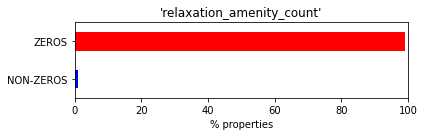

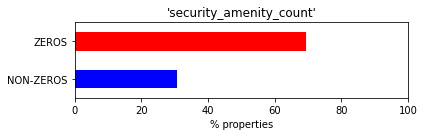

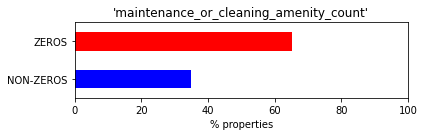

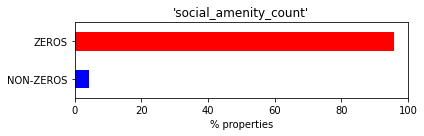

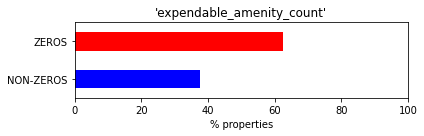

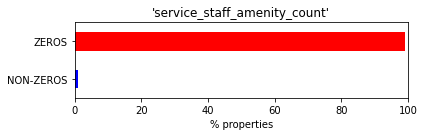

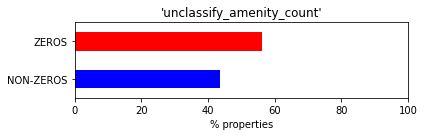

In [1178]:
for col_name in amenities:
    # col_name = 'security_amenity_count'
    # print(df_merged[col_name].value_counts())

    df_TMP = pd.Series(np.where(df_merged[col_name] == 0, 'ZEROS', 'NON-ZEROS'))
    percentages = (df_TMP.value_counts() / df_TMP.value_counts().sum()) * 100
    
#     print()
#     print("------------------------------------")
#     print(percentages)

    fig, ax = plt.subplots(figsize=(6, 2))
    percentages.sort_index().plot.barh(color=['blue', 'red'])

    # Set x and y axis labels
    plt.xlabel('% properties')
    plt.ylabel('')
    # plt.title(f"'{col_name}': zero vs. non-zero entries")
    plt.title(f"'{col_name}'")
    ax.set_xlim(0, 100)

    plt.tight_layout()

    # Show the plot
    plt.show()


In [1179]:
# amenities

In [1180]:
print("Price percentile range for 'Rent'")
print()
print(percl_price_Rent)
print()
print()
print("Price percentile range for 'Sale'")
print()
print(percl_price_Sale)

Price percentile range for 'Rent'

count    2.315600e+04
mean     1.092878e+07
std      8.266022e+08
min      0.000000e+00
2%       0.000000e+00
30%      1.800000e+04
50%      3.200000e+04
60%      5.000000e+04
90%      4.500000e+05
95%      8.000000e+05
99%      2.500000e+06
max      1.000000e+11
Name: price, dtype: float64


Price percentile range for 'Sale'

count    1.731000e+04
mean     2.077500e+09
std      1.839185e+11
min      0.000000e+00
2%       4.500000e+05
30%      5.337000e+06
50%      7.200000e+06
60%      8.220000e+06
90%      2.000000e+07
95%      3.500000e+07
99%      6.500000e+08
max      2.400000e+13
Name: price, dtype: float64


<a id='price-vs-amenities-plot'></a>

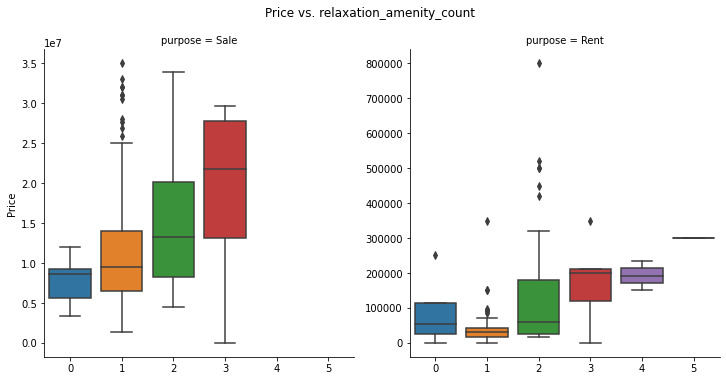

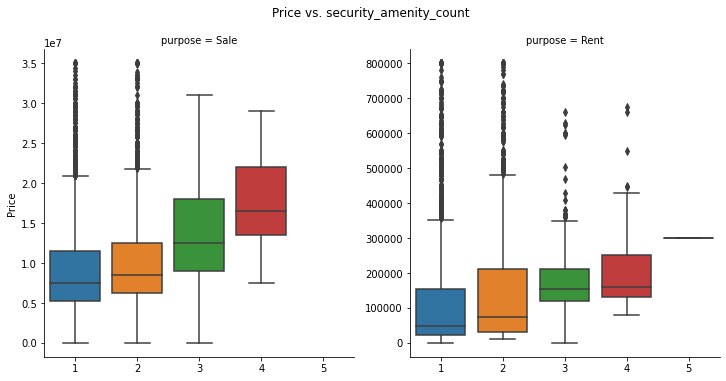

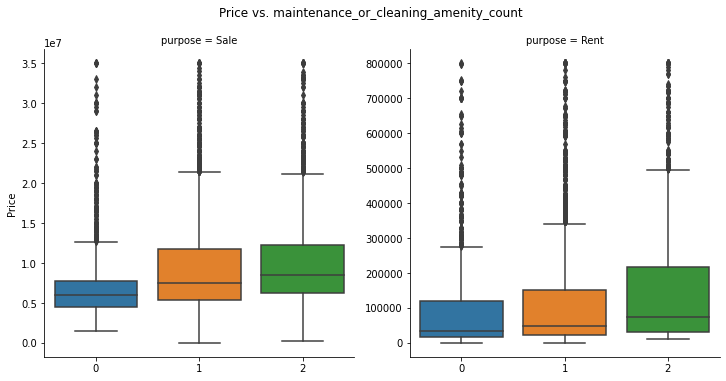

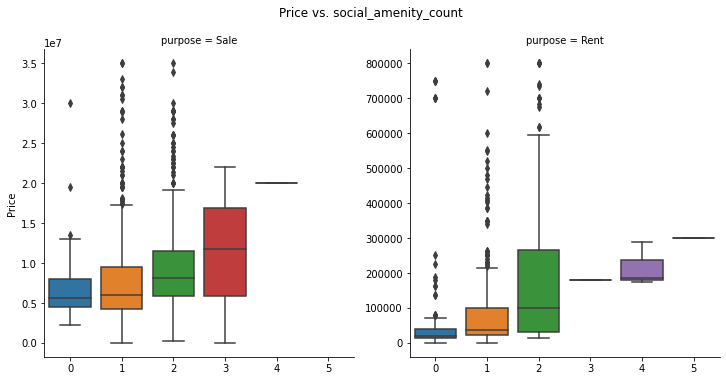

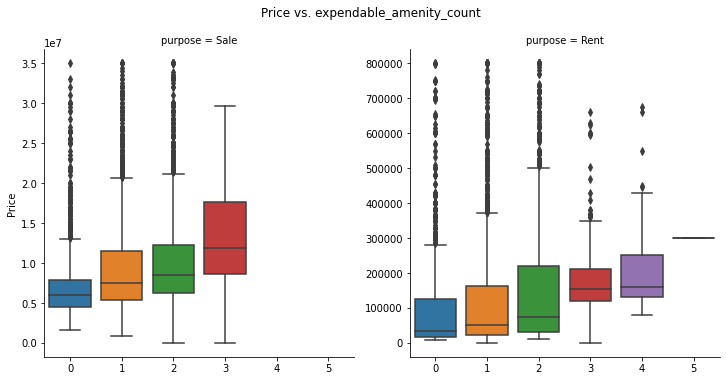

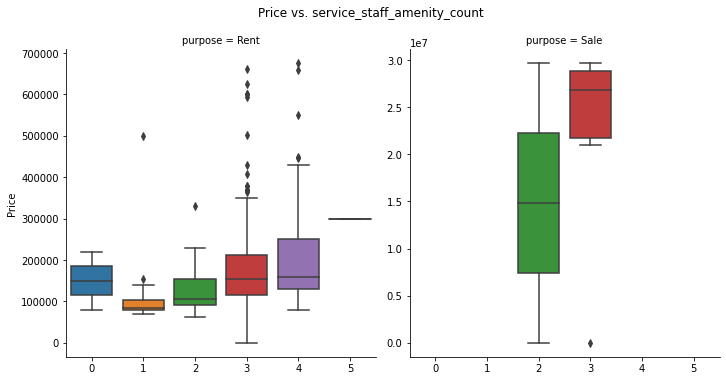

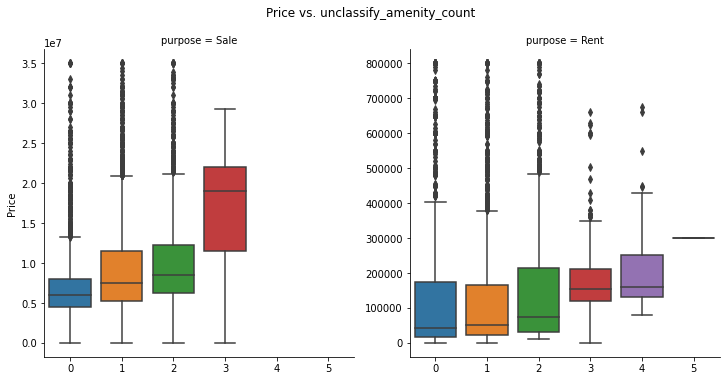

In [1181]:
# Take a subset of data such that properties with very hight values (upper 5%tile) are excluded
df_sub = df_merged[(((df_merged.purpose == 'Rent') & (df_merged.price <= percl_price_Rent['95%'])) | 
                    ((df_merged.purpose == 'Sale') & (df_merged.price <= percl_price_Sale['95%']))
                   )]

for amenity_name in amenities:
    g = sns.catplot(y="price", x="security_amenity_count", 
                    data = df_sub[df_sub[amenity_name] > 0], 
                    kind="box",
                    col= "purpose", 
                    sharey = False
                   )

    g.set_axis_labels('', 'Price')

    # Add row title
    fig = g.fig
    fig.suptitle(f"Price vs. {amenity_name}", y=1.05)

    plt.plot()


<a id='Ans_To_Q2d'></a>
<br>

## (d)	How do they influence the price: linearly / non-linearly / stepwise?

#### This question is answered by looking at plots for question 2(a) and 2(c) above.

<a id='Ans_To_Q8'></a>
<br>

# Question: 8
- Mean prices per building_type (apartment/shop/...); the goal is to understand if it is worth it to have such an attribute, or if building_nature (commercial/residential) is enough.

In [1182]:
# Calculate 'Sale' and 'Rent' means separately and merge
df_mean_price = pd.merge(df_merged[df_merged['purpose'] == 'Sale'].groupby('building_type_comb', as_index=False)['price'].mean(), 
         df_merged[df_merged['purpose'] == 'Rent'].groupby('building_type_comb', as_index=False)['price'].mean(), 
         on='building_type_comb', how='outer', suffixes = ['_sale', '_rent']).fillna(0)


In [1183]:
df_mean_price

,building_type_comb,price_sale,price_rent
0,Apartment,2.100880e+09,5.843884e+06
1,Building,7.466818e+07,1.136901e+08
2,Commercial Space,4.570320e+07,0.000000e+00
3,Duplex,4.516184e+07,4.089677e+05
4,Floor,4.999938e+07,4.800843e+05
5,House,1.168833e+11,2.964626e+05
6,Land,1.042472e+07,0.000000e+00
7,Office,3.833758e+07,3.580366e+05
8,Plot,2.765887e+07,2.708750e+05
9,Residential Plot,2.866166e+06,4.300400e+04


<a id='price-by-type'></a>

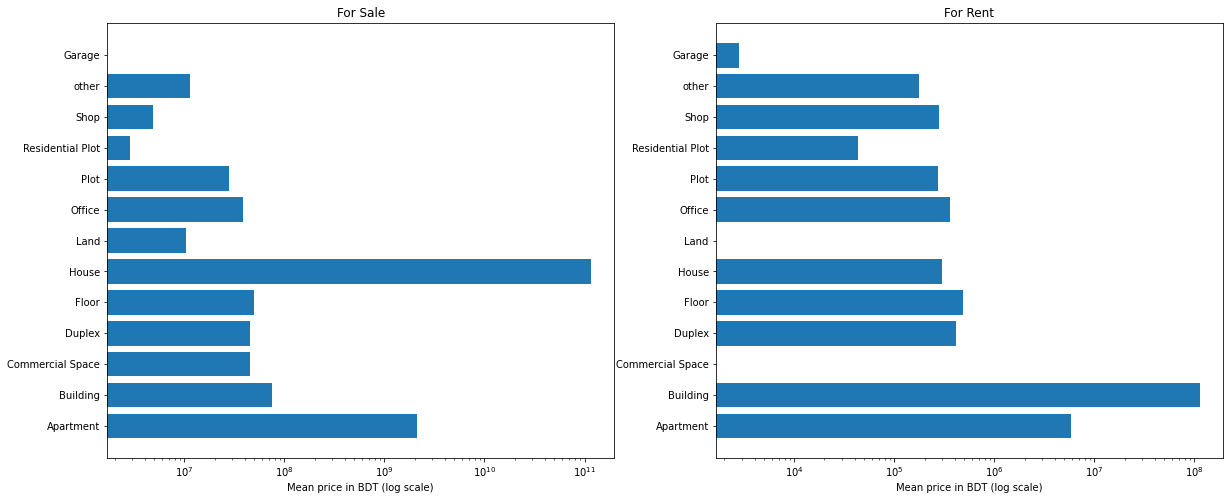

In [1184]:
fig, ax = plt.subplots(1,2)

# First plot
ax[0].barh(df_mean_price['building_type_comb'], df_mean_price['price_sale'])
ax[0].set_title('For Sale')
ax[0].set_xscale('log')
ax[0].set_xlabel('Mean price in BDT (log scale)')


# # Second plot
ax[1].barh(df_mean_price['building_type_comb'], df_mean_price['price_rent'])
ax[1].set_title('For Rent')
ax[1].set_xscale('log')
ax[1].set_xlabel('Mean price in BDT (log scale)')

# Adjust the size of the figure
fig.set_size_inches([20,8])

plt.show()

<BR>
<BR>